In [1]:
# Importing necessities for the analysis
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import optuna
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from functools import partial
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline  
from imblearn.over_sampling import SMOTE  


c:\Users\Admin\Desktop\Portfolio\churn-analysis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("max_colwidth", None)

In [3]:
# Loading the data
df_churn=pd.read_csv('data\Churn_prepared.csv')

<>:2: SyntaxWarning: invalid escape sequence '\C'
<>:2: SyntaxWarning: invalid escape sequence '\C'
C:\Users\Admin\AppData\Local\Temp\ipykernel_11364\3761075145.py:2: SyntaxWarning: invalid escape sequence '\C'
  df_churn=pd.read_csv('data\Churn_prepared.csv')


In [4]:
df_churn.set_index('customerID', inplace=True)

We are going to train a simple model for prediction,Logistic regression is a simple and quick linear model.
Since our data is not very complex or has high dimensions this model can be a good start.
If we are not satisfied with the result we can experiment and compare with more sophisticated models like, random forest, ridge regression, boosting classifiers(XgBoost,LightGBM or CatBoost) or a simple Multi Layer Preceptron(MLP).


now we can start the model training and eval. At this point based on our knwledge of the data structure we need to make some decisions on what evaluation strategy we are going to use.

-Train-Test Split:

    The most simple method would be to use a train-test split on the data. I gives an estimate of how well the model performs on unseen data.
    However, a simple split can generate problems. Since the split is random, it's possible that the model will be evaluated on a sample that is easier or more difficult to predict, we can get a misleading estimate of model performance.

-Cross-Validation:

    Instead of simple train-test split, I prefer to use cross-validation most of the time. We train the model on different subsets (or "folds") of the data and evaluate it separately on the remaining portion. Then we aggregate the results, usually we a more reliable estimate of how the model will perform on new data.

-Stratified Cross-Validation:

    In our dataset, the target variable (Churn) is imbalanced, meaning that the distribution between the positive class (customers who churn) and the negative class (customers who do not churn) is not close to equal, there are more customers who do not churn than those who do.
    For imbalanced datasets, it is advised to use stratified cross-validation. With this method each fold represents the class distribution of the full dataset.



In [5]:
# Define features and target
X = df_churn.drop(columns=['Churn'])  
y = df_churn['Churn']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1)

#Feature scaling (Logistic regression is sensitive to feature scales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test) 

# Define the model
log_reg = LogisticRegression()

# Cross-Validation on the training set
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=skf, scoring='accuracy')

# Print results
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

# Fit the model on the training set
log_reg.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test_scaled)

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Cross-Validation Scores: [0.82497635 0.79375591 0.79545455 0.80018939 0.7907197 ]
Mean Cross-Validation Score: 0.8010191794960007

Confusion Matrix:
[[1166  128]
 [ 205  262]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1294
           1       0.67      0.56      0.61       467

    accuracy                           0.81      1761
   macro avg       0.76      0.73      0.74      1761
weighted avg       0.80      0.81      0.81      1761



At this point we can decide if the results are satisfing and we keep the current model, or we want to improve the predictions. There are many ways to try and do this:

- We can experiment with different classifiers, for example random forest classifier, more complex boosting models(xgb,lgb or catboost) or a MPL(a simple neural network)

- We can engineer new features based on our knowledge of the subject or interaction features with the combination of already existing features.

- We can use model hyperparameter optimization methods like gridsearch or a more sophisticated optuna study.

- We can use ensemble methods to combine the strength o different models with bagging or stacking, or we can use blending of multiple predictions.

- We can use platt scaling or isotonic regression to calibrate the probability outputs of the models, or tune tresholds of label predicitons.



# How to turn the results into value?


Example 1

In [6]:
# Predict the probas 
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# new df with id, predicted probability and true label(just for verification)
churn_with_probas= pd.DataFrame()
churn_with_probas['Churn']=y_test.values
churn_with_probas.index=y_test.index
churn_with_probas['predicted_probability']=y_pred_proba


churn_with_probas.sort_values('predicted_probability',ascending=False).head(20)

,Churn,predicted_probability
customerID,,
9497-QCMMS,1,0.846325
2720-WGKHP,1,0.841681
7216-EWTRS,1,0.839765
1273-MTETI,1,0.818036
8149-RSOUN,1,0.817995
5192-EBGOV,1,0.817058
4750-ZRXIU,1,0.816540
3988-RQIXO,1,0.815974
6861-XWTWQ,1,0.815850



- With this method we can find the customers that are most likely to churn(highest proba)
- The company can reach out to the custmers with ris of churn and try to retain them.

Example 2

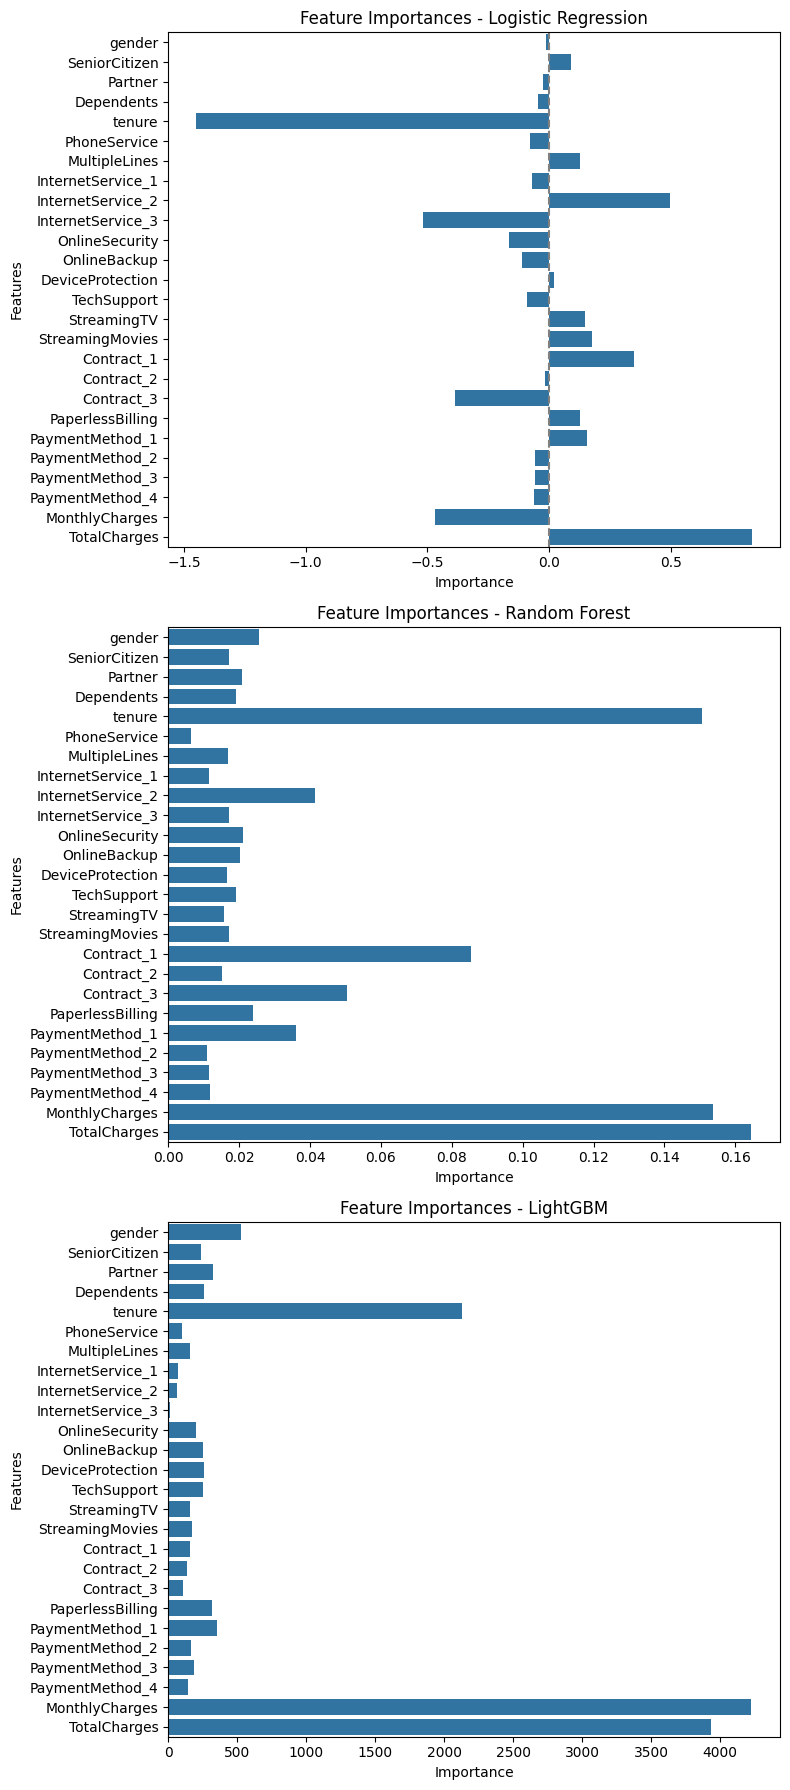

In [7]:

# Features and target
X = df_churn.drop(columns=['Churn'])  
y = df_churn['Churn']

# Scaling for logreg models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=1, stratify=y)

# Models with basic params
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
random_forest = RandomForestClassifier(n_estimators=600, max_depth=25, class_weight='balanced')
lgbm = LGBMClassifier(n_estimators=600, learning_rate=0.1, max_depth=6, metric='f1',verbose=-1)

# Fit the models on the training data
models = [log_reg,random_forest, lgbm]
model_names = ['Logistic Regression', 'Random Forest', 'LightGBM']

# dictionary for feature importances
feature_importances = {}

for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    
    if name=='Logistic Regression': 
        feature_importances[name] = model.coef_[0]
    else :  
        feature_importances[name] = model.feature_importances_

# Convert the feature importances dictionary into a DataFrame
importance_df = pd.DataFrame(feature_importances, index=X.columns)

# Plotting feature importances
num_models = len(model_names)
plt.figure(figsize=(8, 6 * num_models))

for i, name in enumerate(model_names):
    plt.subplot(num_models, 1, i + 1)  # subplot for each model
    sns.barplot(x=importance_df[name], y=importance_df.index)
    plt.title(f'Feature Importances - {name}')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.axvline(0, color='gray', linestyle='--')  

plt.tight_layout() 
plt.show()


- The importances can help us understand what features were most influencial for the models.
- This can help the company to understand better the aspects that influence churn and identify possible targets for marketing campaignes.

### Step 1 of improving prediction performance:

    - We can use SMOTE to oversample the minority class and balance the classes.

In [8]:

# Define features and target
X = df_churn.drop(columns=['Churn'])  
y = df_churn['Churn']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1)

# Create a pipeline with scaling, SMOTE, and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),        
    ('smote', SMOTE(random_state=1)),   
    ('log_reg', LogisticRegression())    
])

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy')

# Print results
print("Mean Cross-Validation Score:", cv_scores.mean())

# Fit the model on the training set
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Mean Cross-Validation Score: 0.7542564361686879

Confusion Matrix:
[[938 356]
 [101 366]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1294
           1       0.51      0.78      0.62       467

    accuracy                           0.74      1761
   macro avg       0.70      0.75      0.71      1761
weighted avg       0.80      0.74      0.75      1761



The accuracy is slightly lower, but the rate of false negatives are halved, this can be important in churn prediction.

### Step 2 of improving prediction performance:

    - We can use gridsearch or optuna to optimize model hyperparameters.
    - Going to combine this step with model comparison.

In [9]:
# Define the objective function for Optuna
def objective(trial, model_choice):
    # MLP Classifier
    if model_choice == "MLP":
        model = MLPClassifier(
            hidden_layer_sizes=trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50)]),
            activation=trial.suggest_categorical('activation', ['relu', 'tanh']),
            alpha=trial.suggest_float('alpha', 1e-4, 1e-2),
            max_iter=trial.suggest_int('max_iter', 200, 2000),
            early_stopping=True
        )
        # Create a pipeline with scaling and SMOTE
        pipeline = Pipeline([('scaler', StandardScaler()), ('smote', SMOTE(random_state=1)), ('classifier', model)])

    # Logistic Regression
    elif model_choice == 'logistic_regression':
        model = LogisticRegression(
            C=trial.suggest_float('C', 1e-4, 100.0), 
            max_iter=trial.suggest_int('max_iter', 100, 2000),  
            solver=trial.suggest_categorical('solver', ['lbfgs', 'sag', 'newton-cg']), 
            tol=trial.suggest_float('tol', 1e-6, 1e-2),  
            fit_intercept=True,
        )
        # Create a pipeline with scaling and SMOTE
        pipeline = Pipeline([('scaler', StandardScaler()), ('smote', SMOTE(random_state=1)), ('classifier', model)])

    # LightGBM Classifier
    elif model_choice == 'LGB':
        params = {
            'objective': 'binary',
            'metric': 'f1',  
            'num_iterations': trial.suggest_int('num_iterations', 300, 1500, step=100),
            'max_depth': trial.suggest_int('max_depth', 5, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2, log=True),
            'lambda_l2': trial.suggest_float('lambda_l2', 15.0, 50.0, log=True),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
            'od_wait': 100,
            'verbose': -1  
        }
        model = LGBMClassifier(**params)
        # Create a pipeline with SMOTE and passthrough for scaling
        pipeline = Pipeline([('smote', SMOTE(random_state=1)), ('classifier', model)])

    # Random Forest Classifier
    elif model_choice == 'random_forest':
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 100, 800), 
            max_depth=trial.suggest_int('max_depth', 3, 75), 
            min_samples_split=trial.suggest_int('min_samples_split', 2, 30), 
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 30), 
            bootstrap=trial.suggest_categorical('bootstrap', [True, False]) 
        )
        # Create a pipeline with SMOTE and passthrough for scaling
        pipeline = Pipeline([('smote', SMOTE(random_state=1)), ('classifier', model)])

    # Cross-validation to evaluate the model
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)  

    # Check for pruning
    if trial.should_prune():
        raise optuna.TrialPruned()    
    
    return scores.mean()

# Model choices
model_choices = ['logistic_regression', 'LGB', 'MLP', 'random_forest']
results = []

# Loop over the models
for model in model_choices:
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=1))
    
    # Use partial to avoid redefining the function for each model
    objective_func = partial(objective, model_choice=model)
    study.optimize(objective_func, n_trials=100, n_jobs=-1)

    # Get the best hyperparameters and store them
    best_params = study.best_params
    best_score = study.best_value

    results.append({'model': model, 'best_score': best_score, 'best_params': best_params})

results_df = pd.DataFrame(results)

print(results_df)

[I 2024-10-11 02:28:19,790] A new study created in memory with name: no-name-6ebf79dd-5d51-48e9-bf95-6b6627374da3


[I 2024-10-11 02:28:25,392] Trial 5 finished with value: 0.7550145494681919 and parameters: {'C': 41.98764736992478, 'max_iter': 1109, 'solver': 'lbfgs', 'tol': 0.00832110705876975}. Best is trial 5 with value: 0.7550145494681919.
[I 2024-10-11 02:28:25,443] Trial 1 finished with value: 0.7557706917806255 and parameters: {'C': 64.0925113988242, 'max_iter': 1527, 'solver': 'newton-cg', 'tol': 0.002378535272312052}. Best is trial 1 with value: 0.7557706917806255.
[I 2024-10-11 02:28:25,528] Trial 2 finished with value: 0.7534985020498265 and parameters: {'C': 32.6884276910177, 'max_iter': 1692, 'solver': 'lbfgs', 'tol': 0.005207814940831357}. Best is trial 1 with value: 0.7557706917806255.
[I 2024-10-11 02:28:25,617] Trial 6 finished with value: 0.7557706917806255 and parameters: {'C': 33.05909229051521, 'max_iter': 1807, 'solver': 'newton-cg', 'tol': 0.0024650776098462386}. Best is trial 1 with value: 0.7557706917806255.
[I 2024-10-11 02:28:25,870] Trial 3 finished with value: 0.7544467

                 model  best_score  \
0  logistic_regression    0.755960   
1                  LGB    0.788524   
2                  MLP    0.761824   
3        random_forest    0.787007   

                                                                                                                                                                                         best_params  
0                                                                                                        {'C': 59.60025766689852, 'max_iter': 1432, 'solver': 'lbfgs', 'tol': 0.0005763900390195171}  
1  {'num_iterations': 300, 'max_depth': 7, 'learning_rate': 0.05496963700232419, 'lambda_l2': 15.025444011288787, 'bagging_fraction': 0.9980075740250467, 'bagging_freq': 3, 'min_data_in_leaf': 50}  
2                                                                                            {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'alpha': 0.0072762954252566835, 'max_iter': 251}  
3            

In [15]:
results_df

,model,best_score,best_params
0,logistic_regression,0.755960,"{'C': 59.60025766689852, 'max_iter': 1432, 'solver': 'lbfgs', 'tol': 0.0005763900390195171}"
1,LGB,0.788524,"{'num_iterations': 300, 'max_depth': 7, 'learning_rate': 0.05496963700232419, 'lambda_l2': 15.025444011288787, 'bagging_fraction': 0.9980075740250467, 'bagging_freq': 3, 'min_data_in_leaf': 50}"
2,MLP,0.761824,"{'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'alpha': 0.0072762954252566835, 'max_iter': 251}"
3,random_forest,0.787007,"{'n_estimators': 138, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 10, 'bootstrap': True}"


In [16]:
# Model mapping
model_mapping = {
    "logistic_regression": LogisticRegression,
    "LGB": LGBMClassifier,
    "extra_tree": ExtraTreesClassifier,
    "MLP": MLPClassifier,
    "random_forest": RandomForestClassifier
}

# Store results
model_results = []
c_reports = {}

# Loop through the results df
for index, row in results_df.iterrows():
    model_name = row['model']
    params = row['best_params']
    
    # Create the model with the parameters
    model = model_mapping[model_name](**params)

    # Create a pipeline that includes SMOTE and the model
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=1)),  # Resampling step
        ('classifier', model)               # Model step
    ])
    
    # Use cross_val_predict to get predicted values on the training set
    y_train_pred = cross_val_predict(pipeline, X_train, y_train, cv=5)
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate metrics for training predictions
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel() 

    # Calculate metrics for test predictions
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_pred).ravel()
    c_report = classification_report(y_test, y_test_pred)

    # Append results
    model_results.append({
        "model": model_name,
        "train_accuracy": train_accuracy,
        "train_precision": train_precision,
        "train_recall": train_recall,
        "train_f1_score": train_f1,
        "train_roc_auc": train_roc_auc,
        "train_false_positives": fp,
        "train_false_negatives": fn,
        "test_accuracy": test_accuracy,
        "test_precision": test_precision,
        "test_recall": test_recall,
        "test_f1_score": test_f1,
        "test_roc_auc": test_roc_auc,
        "test_true_positives": tp_test,
        "test_false_positives": fp_test,
        "test_true_negatives": tn_test,
        "test_false_negatives": fn_test
    })
    c_reports[model_name] = c_report

# Create a DataFrame from the results
model_results_df = pd.DataFrame(model_results)

c:\Users\Admin\Desktop\Portfolio\churn-analysis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Admin\Desktop\Portfolio\churn-analysis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

In [17]:
model_results_df

,model,train_accuracy,train_precision,train_recall,train_f1_score,train_roc_auc,train_false_positives,train_false_negatives,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc,test_true_positives,test_false_positives,test_true_negatives,test_false_negatives
0,logistic_regression,0.787580,0.598177,0.608417,0.603253,0.730368,573,549,0.798978,0.616977,0.638116,0.627368,0.747574,298,185,1109,169
1,LGB,0.782090,0.590353,0.584879,0.587603,0.719115,569,582,0.776831,0.579060,0.580300,0.579679,0.714029,271,197,1097,196
2,MLP,0.715259,0.472843,0.633381,0.541463,0.689113,990,514,0.634867,0.408524,0.841542,0.550035,0.700910,393,569,725,74
3,random_forest,0.781522,0.575702,0.672611,0.620395,0.746743,695,459,0.783078,0.578558,0.670236,0.621032,0.747019,313,228,1066,154


In [18]:
for model, report in c_reports.items():
    print(model)
    print(report)

logistic_regression
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1294
           1       0.62      0.64      0.63       467

    accuracy                           0.80      1761
   macro avg       0.74      0.75      0.74      1761
weighted avg       0.80      0.80      0.80      1761

LGB
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1294
           1       0.58      0.58      0.58       467

    accuracy                           0.78      1761
   macro avg       0.71      0.71      0.71      1761
weighted avg       0.78      0.78      0.78      1761

MLP
              precision    recall  f1-score   support

           0       0.91      0.56      0.69      1294
           1       0.41      0.84      0.55       467

    accuracy                           0.63      1761
   macro avg       0.66      0.70      0.62      1761
weighted avg       0.78      0.63      0.65   

# Evaluation of Models
### Important Metrics

- Accuracy: Overall percentage of correct predictions.
- Precision for Class 1 (Churn): The proportion of predicted churns that were actually correct. High precision -minimizes false positives (non-churn predicted as churn).
- Recall for Class 1 (Churn): The proportion of actual churns that were correctly identified. High recall minimizes -false negatives (missed churns).
- F1-score for Class 1: The harmonic mean of precision and recall, balancing both.
- False Negatives: Low false negatives indicate a better ability to catch customers likely to churn.

### Model Performance

- Logistic Regression:

    - Training Accuracy: ~80%
    - Test Accuracy: ~81%
    - Precision for Class 1: 68%
    - Recall for Class 1: 53%
    - F1-Score for Class 1: 59%
    - False Negatives: 221


    Insights: The model has good overall performance, but its recall for churn predictions is relatively -low, leading to a higher number of missed churns, which could be costly.

- LightGBM (Boosting Model):
    - Training Accuracy: ~80%
    - Test Accuracy: ~80%
    - Precision for Class 1: 67%
    - Recall for Class 1: 50%
    - F1-Score for Class 1: 57%
    - False Negatives: 233
    Insights: LightGBM has performance metrics similar to Logistic Regression, but with slightly lower scores, particularly in recall, which means it also struggles with false negatives.

- MLP (Neural Network):
    - Training Accuracy: ~72%
    - Test Accuracy: ~79%
    - Precision for Class 1: 72%
    - Recall for Class 1: 37%
    - F1-Score for Class 1: 48%
    - False Negatives: 296
    Insights: MLP scores the lowest across metrics, particularly in recall, indicating many actual churners are missed. However, it has the lowest false positive rate, which could be advantageous in high-cost churn scenarios.

- Random Forest:
    - Training Accuracy: ~80%
    - Test Accuracy: ~81%
    - Precision for Class 1: 70%
    - Recall for Class 1: 48%
    - F1-Score for Class 1: 57%
    False Negatives: 244
    Insights: Random Forest exhibits performance similar to Logistic Regression and LightGBM but has a higher rate of false negatives.

### Conclusion and Next Steps

    Best Performing Model: Logistic Regression has the best overall performance in terms of accuracy and precision. However, the recall indicates room for improvement in identifying churners.
    MLP: Despite lower scores, MLP offers a low false positive rate, which is beneficial in minimizing unnecessary customer outreach for churn prevention.

### Next Steps for Improvement:

To enhance the predictive performance of these models, consider the following strategies:

    Resampling the Imbalanced Data: Techniques like SMOTE or undersampling to balance the classes.
    Tuning Prediction Thresholds: Adjust thresholds to improve precision and recall based on business needs.
    Calibrating Probabilities: Use methods like Platt scaling or isotonic regression to better align predicted probabilities with actual outcomes.
    Feature Selection: Utilize feature importances or domain knowledge to refine the feature set.
    Ensemble Methods: Explore bagging or stacking approaches to leverage predictions from multiple models for improved accuracy.